In [1]:
#import libraries
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import datetime
import pandas as pd
%matplotlib inline

In [2]:
#define date range
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2021, 5, 31)
years = (end - start).days / 365.25

In [3]:
#define starting variables
symbols = ["SPY"]
systems = ["Sys", "BuyHold"]
starting_balance = 10000
slow_ma = 200
fast_ma = 5
rsi_period = 2
rsi_thresh = 5
trade_open = False

In [4]:
#download data
price = yf.download(symbols[0], start, end)
price = price.drop(["Volume", "Adj Close"], axis=1)

price.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2021-05-24,417.339996,420.320007,417.079987,419.170013
2021-05-25,420.329987,420.709991,417.619995,418.239990
2021-05-26,418.869995,419.609985,417.760010,419.070007
2021-05-27,420.170013,420.720001,418.989990,419.290009
2021-05-28,420.970001,421.250000,419.790009,420.040009


In [5]:
#calculate benchmark return and balance
price['BuyHold_Ret'] = price.Close / price.Close.shift(1)
price.BuyHold_Ret.iat[0] = 1
price['BuyHold_Bal'] = starting_balance * price.BuyHold_Ret.cumprod()

price['BuyHold_Signal'] = True
price['BuyHold_Trade'] = True
price.tail()

,Open,High,Low,Close,BuyHold_Ret,BuyHold_Bal,BuyHold_Signal,BuyHold_Trade
Date,,,,,,,,
2021-05-24,417.339996,420.320007,417.079987,419.170013,1.010194,28821.315921,True,True
2021-05-25,420.329987,420.709991,417.619995,418.239990,0.997781,28757.369333,True,True
2021-05-26,418.869995,419.609985,417.760010,419.070007,1.001985,28814.439696,True,True
2021-05-27,420.170013,420.720001,418.989990,419.290009,1.000525,28829.566552,True,True
2021-05-28,420.970001,421.250000,419.790009,420.040009,1.001789,28881.135095,True,True


In [6]:
#calculate benchmark drawdown
price['BuyHold_Peak'] = price.BuyHold_Bal.cummax()
price['BuyHold_DD'] = price.BuyHold_Bal - price.BuyHold_Peak

bench_dd = round(((price.BuyHold_DD / price.BuyHold_Peak).min() * 100), 2)

bench_dd

np.float64(-56.47)

In [7]:
def calculate_inputs(df):
    #calculate inputs required for system
    
    #calculate moving averages
    df['Fast_MA'] = df.Close.rolling(window = fast_ma).mean()
    df['Slow_MA'] = df.Close.rolling(window = slow_ma).mean()
    
    #daily change
    df['Change'] = df.Close.diff()
    #separate into up and down days
    df['Gain'] = df.Change.clip(lower = 0)
    df['Loss'] = -1 * df.Change.clip(upper = 0)
    
    #average gains with EMA smoothing (Wilder)
    df['Avg_Gain'] = ((df.Gain.shift(1) * (rsi_period - 1)) + df.Gain) / rsi_period
    df['Avg_Loss'] = ((df.Loss.shift(1) * (rsi_period - 1)) + df.Loss) / rsi_period
    
    #relative strength
    df['RS'] = df.Avg_Gain / df.Avg_Loss
    
    #RSI
    df['RSI'] = 100 - (100 / (1 + df.RS))
    
    return df

In [8]:
price = calculate_inputs(price)

In [9]:
def generate_signals(df, s):
    #generate entries and exits
    #entry is taken at the close
    df[f'{s}_Signal'] = (df.RSI < rsi_thresh) & (df.Close > df.Slow_MA)
    #exit is taken at the close
    df[f'{s}_Exit'] = (df.Close > df.Fast_MA)
    
    return df

In [10]:
for sys in systems:
    price = generate_signals(price, sys)

In [11]:
#create empty list for trades
trades_list = []

#iterate through rows to work out entries and exits
for i, row in price.iterrows():
    #if there is currently no trade
    if trade_open == False:
        #check if long signal was generated at the close and enter at the same time
        if row.Sys_Signal == True:
            entry_date = i
            entry_price = row.Close
            trade_open = True
    #check if a trade is already open
    elif trade_open == True:
        #check if an exit signal has been generated on today's close and sell shares
        if row.Sys_Exit == True:
            exit_date = i
            exit_price = row.Close
            trade_open = False
            #store trade data in a list
            trade = [entry_date, entry_price, exit_date, exit_price, True]
            #append trade to overall trade list
            trades_list.append(trade)

In [12]:
trades = pd.DataFrame(trades_list, columns = ['Entry_Date', 'Entry_Price', 'Exit_Date', 'Exit_Price', "Sys_Trade"])

In [13]:
#calculate return of each trade as well as the trade duration
trades['Return'] = trades.Exit_Price / trades.Entry_Price
dur = []
for i, row in trades.iterrows():
    d1 = row.Entry_Date
    d2 = row.Exit_Date
    dur.append(np.busday_count(d1.date(), d2.date()))

trades['Duration'] = dur
    
trades.head()

,Entry_Date,Entry_Price,Exit_Date,Exit_Price,Sys_Trade,Return,Duration
0,2002-03-13,116.040001,2002-03-15,116.650002,True,1.005257,2
1,2002-03-21,115.290001,2002-03-27,114.570000,True,0.993755,4
2,2003-04-25,90.230003,2003-04-28,91.790001,True,1.017289,1
3,2003-05-01,91.900002,2003-05-02,93.209999,True,1.014255,1
4,2003-05-08,92.449997,2003-05-09,93.730003,True,1.013845,1


In [14]:
#create a new dataframe with an index of exit prices
returns = pd.DataFrame(index = trades.Exit_Date)

#add the Return column to this new data frame
returns = returns.assign(Sys_Ret = pd.Series(trades.Return).values)
returns = returns.assign(Sys_Trade = pd.Series(trades.Sys_Trade).values)
returns = returns.assign(Duration = pd.Series(trades.Duration).values)

returns.head()

,Sys_Ret,Sys_Trade,Duration
Exit_Date,,,
2002-03-15,1.005257,True,2
2002-03-27,0.993755,True,4
2003-04-28,1.017289,True,1
2003-05-02,1.014255,True,1
2003-05-09,1.013845,True,1


In [15]:
#add the returns from the trades to the main data frame
price = pd.concat([price, returns], axis = 1)

In [16]:
#fill all the NaN return values with 1 as there was no profit or loss on those days
price['Sys_Ret'] = price['Sys_Ret'].fillna(1)
#fill all the NaN trade values with False as there was no trade on those days
price['Sys_Ret'] = price['Sys_Ret'].fillna(False)

#calculate system balance
price['Sys_Bal'] = starting_balance * price.Sys_Ret.cumprod()

active_trades = np.where(price["Sys_Trade"] == True, True, False)
#populate trades column based on duration
for count, t in enumerate(active_trades):
    if t == True:
        dur = price["Duration"].iat[count]
        for i in range(int(dur)):
            #starting from the exit date, move backwards and mark each trading day
            price["Sys_Trade"].iat[count - i] = True

price.head()

,Open,High,Low,Close,BuyHold_Ret,BuyHold_Bal,BuyHold_Signal,BuyHold_Trade,BuyHold_Peak,BuyHold_DD,...,Avg_Loss,RS,RSI,Sys_Signal,Sys_Exit,BuyHold_Exit,Sys_Ret,Sys_Trade,Duration,Sys_Bal
2000-01-03,148.25000,148.25000,143.875000,145.4375,1.000000,10000.000000,False,True,10000.000000,0.000000,...,NaN,NaN,NaN,False,False,False,1.0,NaN,NaN,10000.0
2000-01-04,143.53125,144.06250,139.640625,139.7500,0.960894,9608.938547,False,True,10000.000000,-391.061453,...,NaN,NaN,NaN,False,False,False,1.0,NaN,NaN,10000.0
2000-01-05,139.93750,141.53125,137.250000,140.0000,1.001789,9626.128062,False,True,10000.000000,-373.871938,...,2.84375,0.043956,4.210526,False,False,False,1.0,NaN,NaN,10000.0
2000-01-06,139.62500,141.50000,137.750000,137.7500,0.983929,9471.422432,False,True,10000.000000,-528.577568,...,1.12500,0.111111,10.000000,False,False,False,1.0,NaN,NaN,10000.0
2000-01-07,140.31250,145.75000,140.062500,145.7500,1.058076,10021.486893,False,True,10021.486893,0.000000,...,1.12500,3.555556,78.048780,False,True,True,1.0,NaN,NaN,10000.0


In [18]:
def generate_trades(df):
    pass

In [19]:
#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round((min(price.Sys_DD / price.Sys_Peak) * 100), 2)

sys_dd

-13.66

In [20]:
results = []
results.append(price)
# for sym in symbols:
#     result = backtest(sym)
#     results.append(result)

In [21]:
#calculate metrics
def get_metrics(system, data):
    metrics = {}
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    rod = sys_cagr / abs(sys_dd)
 
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    signals = data[f"{system}_Signal"].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round((trades_triggered / len(data)) * 100)
    rbe = round((sys_cagr / tim) * 100, 2)
    rbeod = rbe / abs(sys_dd) # return by exposure by drawdown (assuming drawdown doesn't scale as TIM increases. Could be wrong)
    gaps = ((data[f"{system}_Trade"] == True) & (data.Open > data.High.shift(1))).sum()
    non_gaps = ((data[f"{system}_Trade"] == True) & (data.Open <= data.High.shift(1))).sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    ret_size = np.where(data[f"{system}_Trade"] == True, data[f"{system}_Ret"], 1)
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    max_up_move = (data[f"{system}_Ret"].max() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    max_down_move = (data[f"{system}_Ret"].min() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    metrics["Time_in_Market"] = round(tim, 2)
    metrics["Return_By_Exposure"] = rbe
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    metrics["Return_Over_Drawdown"] = round(rod, 2)
    metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    metrics["Gap"] = round(gaps)
    metrics["No_Gap"] = round(non_gaps)
    metrics["Wins"] = round(wins, 2)
    metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    metrics["Max_Trade_Return_pct"] = round(max_up_move, 2)
    metrics["Max_Trade_Loss_pct"] = round(max_down_move, 2)
    metrics["Avg_Trade_Return_pct"] = round(avg_up_move, 2)
    metrics["Avg_Trade_Loss_pct"] = round(avg_down_move, 2)
    metrics["Avg_RR"] = avg_rr
    
    return metrics

In [22]:
full_metrics = {}
for count, res in enumerate(results):
    sys_metrics = {}
    for s in systems:
        sys_metrics.update({s: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)
    full_metrics.update({symbols[count]: sys_metrics_df})

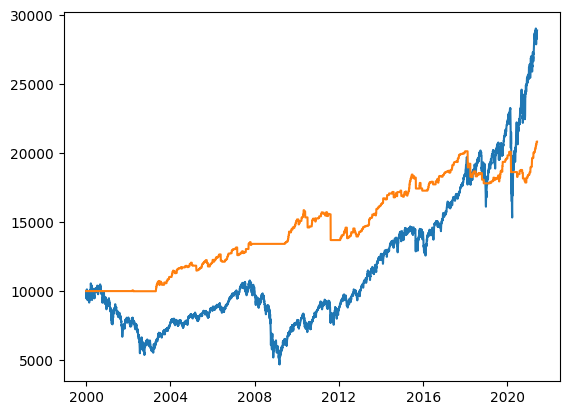

In [23]:
#plot results
plt.plot(price.BuyHold_Bal)
plt.plot(price.Sys_Bal)

plt.show()

In [24]:
for m in full_metrics:
    print(m)
    print(full_metrics[m])

SPY
                           Sys   BuyHold
Start_Balance         10000.00  10000.00
Final_Balance         20828.82  28881.14
Total_Return            108.29    188.81
Annual_Return             3.49      5.08
Time_in_Market           22.00    100.00
Return_By_Exposure       15.86      5.08
Max_Drawdown            -13.66    -56.47
Return_Over_Drawdown      0.26      0.09
RBE_Over_Drawdown         1.16      0.09
Signals                 698.00    698.00
Trades                 1164.00   5386.00
Gap                     210.00   1164.00
No_Gap                  954.00   4221.00
Wins                    276.00   2910.00
Losses                   92.00   2456.00
Winrate                  75.00     54.23
Max_Trade_Return_pct      2.94     14.52
Max_Trade_Loss_pct      -12.00    -10.94
Avg_Trade_Return_pct      0.75      0.78
Avg_Trade_Loss_pct       -1.40     -0.87
Avg_RR                    0.53      0.90
